In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as scistats
import scipy.optimize as sciopt

In [11]:
import importlib; 
try:
    import engmod.structfem as sfem; importlib.reload(sfem)
except:
    try:
        import add_engmod
        import engmod.structfem as sfem; #importlib.reload(sfem)    
        print("EngMod Development Mode Activated. Not applicable/relevant to students.")        
    except Exception as e:
        print(e)
        print("Engmod is not located in the correct folder. ")

In [12]:
######   Sut in MPa!!  #######

def fatigue_strength_fraction(Sut): 
    """
    Inputs:

    Ultimate strength Sut in MPa

    """
    if Sut < 490:
        f = 0.9
    else:
        Se = 0.5 * Sut
        Ne = 1E6
        sigmaf = Sut + 345
        b = - np.log10(sigmaf/Se)/np.log10( 2 * Ne)
        f = sigmaf / Sut * (2 * 10**3) ** b
    return f

######   Sut, Se,sigma_reversed  in MPa!!  #######
def number_cycles_to_failure(sigma_reversed,Sut,Se): # Sut, Se in MPa!!
    f = fatigue_strength_fraction(Sut)
    a = (f * Sut)**2 / Se 
    b = (-1/3 * np.log10(f * Sut/Se))
    N = (sigma_reversed/a)**(1/b)
    return N


def marin_surface_factor(Sut,surface_finish): 
    '''
    Sut: Ultimate strength in MPa
    
    surface_finish must be one of the following options: 
    * ground
    * machined
    * cold-drawn
    * hot-rolled
    * as-forged    
    '''
    if surface_finish == "ground": 
        
        # a = 1.58; b = -0.085
        a = 1.38; b = -0.067    
    
    elif (surface_finish == "machined") or (surface_finish == "cold-drawn"):
        #a = 4.51; b = -0.265
        a = 3.04; b = -0.217
            
    elif (surface_finish == "hot-rolled"): 
        
        #a = 57.7; b = -0.718
        a = 38.6; b = -0.65
        
    elif (surface_finish == "as-forged"): 
        
        #a = 272.; b = -0.995
        a = 54.9; b = -0.758
        
        
    else:
        raise ValueError("You supplied the following surface finish: '{}' which does not exist. Please check your spelling - only the following options are available:  \n* ground\n* machined\n* cold-drawn\n* hot-rolled\n* as-forged   ".format(surface_finish))
        
    return a * Sut ** b

def marin_loading_factor(load_type): 
    
    if load_type == "bending": 
        return 1 
    if load_type == "axial": 
        return 0.85
    if load_type == "torsion":
        return 0.59
    raise ValueError("You must supply bending, axial or torsion as an input.")
    
def marin_temperature_factor(temperature_degrees_celcius): 
    x = 20,50,100,150,200,250,300,350,400,450,500,550,660
    y = 1,1.010,1.020,1.025,1.020,1.00,0.975,0.943,0.9,0.843,0.768,0.672,0.549
    
    import scipy.interpolate as sciint
    
    kd = float(sciint.interp1d(x,y,kind="linear")(temperature_degrees_celcius))

    #kd = 0.975 + 0.432 * 1E-3 * Tf - 0.115 * 1E-5 * Tf **2 + 0.104 * 1E-8 * Tf **3 - 0.595 * 1E-12 * Tf**4
    
    return kd
    
def marin_reliability_factor(reliability_fraction): 
    if (reliability_fraction < 0) | (reliability_fraction > 1):
        raise ValueError("Please insert a value between 0 and 1")
    return 1 - 0.08 * scistats.norm.ppf(reliability_fraction)

def notch_sensitivity(notch_radius_mm,Sut_MPa): 
    
    Sut_kpi = Sut_MPa * 0.14492753623188406
        
    sqrt_a = 0.246 - 3.081E-3 * Sut_kpi + 1.51*1E-5*Sut_kpi**2 - 2.67*1E-8 * Sut_kpi**3

    radius_inches = 1/25.4 * notch_radius_mm

    sqrt_r = np.sqrt(radius_inches)    

    sqrt_r = np.sqrt(radius_inches)

    q = 1/(1 + sqrt_a/sqrt_r)
    
    return q


In [13]:
std_sizes = {}
std_sizes['12x2'] = np.array([12e-3, 2e-3, 0.628e-4, 0.082e-8])
std_sizes['16x2'] = np.array([16e-3, 2e-3, 0.879e-4, 0.220e-8])
std_sizes['16x3'] = np.array([16e-3, 3e-3, 1.225e-4, 0.273e-8])
std_sizes['20x4'] = np.array([20e-3, 4e-3, 2.010e-4, 0.684e-8])
std_sizes['25x4'] = np.array([25e-3, 4e-3, 2.638e-4, 1.508e-8])
std_sizes['25x5'] = np.array([25e-3, 5e-3, 3.140e-4, 1.669e-8])
std_sizes['30x4'] = np.array([30e-3, 4e-3, 3.266e-4, 2.827e-8])
std_sizes['30x5'] = np.array([30e-3, 5e-3, 3.925e-4, 3.198e-8])
std_sizes['42x4'] = np.array([42e-3, 4e-3, 4.773e-4, 8.717e-8])
std_sizes['42x5'] = np.array([42e-3, 5e-3, 5.809e-4, 10.13e-8])
std_sizes['50x4'] = np.array([50e-3, 4e-3, 5.778e-4, 15.409e-8])
std_sizes['50x5'] = np.array([50e-3, 5e-3, 7.065e-4, 18.118e-8])

In [14]:
x1 = 0; y1 = 0
x2 = 370; y2 = -430
dist0 = np.sqrt((x2-x1)**2+(y2-y1)**2)

x1 = 370; y1 = -430
x2 = -60.43; y2 = -430
dist1 = np.sqrt((x2-x1)**2+(y2-y1)**2)

x1 = -60.43; y1 = -430
x2 = 0; y2 = 0
dist2 = np.sqrt((x2-x1)**2+(y2-y1)**2)

x1 = -60.43; y1 = -430
x2 = -552.94; y2 = 31.62
dist3 = np.sqrt((x2-x1)**2+(y2-y1)**2)

x1 = -552.94; y1 = 31.62
x2 = -535.4; y2 = 89
dist4 = np.sqrt((x2-x1)**2+(y2-y1)**2)

x1 = -535.4; y1 = 89
x1 = 0; y1 = 0
dist5 = np.sqrt((x2-x1)**2+(y2-y1)**2)

dist6 = dist0
dist7 = dist1

lengths = [dist0/1e3, dist1/1e3, dist2/1e3, dist3/1e3, dist4/1e3, dist5/1e3, dist6/1e3, dist7/1e3]

In [15]:
d_main, _, A_main, I_main = std_sizes['20x4']

d_rear, _, A_rear, I_rear = std_sizes['12x2']

Fs = 490.5
Fp = 490.5
Fh = 490.5

# Aluminium 6061-T4
rho = 2700 
E = 68.9e9
Sy = 145e6
Sut = 241e6

w = 523.8

nodecoor = np.array([
                     [0, 0],        
                     [370e-3, -430e-3],
                     [-60.43e-3, -430e-3],
                     [-552.94e-3,31.62e-3], 
                     [-535.4e-3, 89e-3]])

elemconn = np.array([
                     [0,1],
                     [1,2],
                     [2,0],
                     [2,3],
                     [3,4],
                     [4,0],
                     [0,1],
                     [1,2]]) # seat- and chainstays elements are duplicated

prescribed_displacement = np.array([
                                    [3,0,0], #Fix Nodes 3 and 1; attachment of front fork and rear wheel.
                                    [3,1,0],
                                    [1,0,0],
                                    [1,1,0]])

prescribed_forces = np.array([
                            [0, 1, -Fs],
                            [2, 1, -Fp],
                            [4, 1, -Fh]])

# Element properties
elemprop = {}
# Young's modulus [Pa]
elemprop["E"] = np.ones(elemconn.shape[0]) * E
# Area moment of inertia [m^4]
elemprop["I"] = np.array([I_rear, I_rear,I_main,I_main,I_main,I_main,I_rear,I_rear])
# Cross-sectional area [m^2]
elemprop["A"] = np.array([A_rear, A_rear,A_main,A_main,A_main,A_main,A_rear,A_rear])
# Density [kg/m^3]
elemprop["density"] = np.ones(elemconn.shape[0]) * rho

fmn = sfem.FEM_Beam_2D(nodecoor,                
                       elemconn,                
                       prescribed_displacement, 
                       prescribed_forces,       
                       elemprop)    
fmn.solve()

Mff,Kff = fmn.dynamic_make_matrices()
_,Fss1,_ = fmn.make_force_global(0,1,-Fs)
_,Fss2,_ = fmn.make_force_global(2,1,-Fp)
_,Fss3,_ = fmn.make_force_global(4,1,-Fh)
Fss = Fss1 + Fss2 + Fss3
Uss = np.linalg.solve(Kff - Mff*w**2,Fss)
U_global = fmn.dynamic_make_global_displacement(Uss)

stress_top = []
stress_bot = []
SFbu = []
S_a = []
rear = [0, 1, 6, 7]
main = [2, 3, 4, 5]
c1_top = -((d_main/2)/I_main)
c2_top = -((d_rear/2)/I_rear)
c1_bot = -((-d_main/2)/I_main)
c2_bot = -((-d_rear/2)/I_rear)

for i in np.arange(fmn.nelem):
    if i in rear:
        dict_moment = fmn.post_get_bending_moment(i,npoints=10, displacement=U_global)
        St = (dict_moment["moment"]*c2_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
        Sb = (dict_moment["moment"]*c2_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
        stress_top.append(St)
        stress_bot.append(Sb)

        Pcr = np.pi**2 * E * I_rear/((0.5*lengths[i])**2) #fixed-fixed: K = 0.5
        P = fmn.post_axial_stress_strain(displacement=U_global)['stress'][i]*A_rear
        
        stress_a = max(max(abs(dict_moment["moment"]*c2_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])), 
                      max(abs(dict_moment["moment"]*c2_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])))
        
        S_a.append(stress_a)
        
#         print(Pcr, P, i)
        if P< 0:   
            SFbu.append(Pcr/abs(P))

    elif i in main:
        dict_moment = fmn.post_get_bending_moment(i,npoints=10, displacement=U_global)
        St = (dict_moment["moment"]*c1_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
        Sb = (dict_moment["moment"]*c1_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
        stress_top.append(St)
        stress_bot.append(Sb)

        Pcr = np.pi**2 * E * I_main/((0.5**lengths[i])**2) #fixed-fixed: K = 0.5
        P = fmn.post_axial_stress_strain(displacement=U_global)['stress'][i]*A_main
        
        stress_a = max(max(abs(dict_moment["moment"]*c1_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])), 
              max(abs(dict_moment["moment"]*c1_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])))
        
        S_a.append(stress_a)
        
#         print(Pcr, P, i)
        if P < 0:
            SFbu.append(Pcr/abs(P))

stress_top_c = np.concatenate(stress_top)
stress_bot_c = np.concatenate(stress_bot)

max_comp_top = min(stress_top_c)
max_comp_bot = min(stress_top_c)
max_ten_top = max(stress_top_c)
max_ten_bot = max(stress_top_c)

max_comp = min(max_comp_bot, max_comp_top)
max_ten = max(max_ten_bot, max_ten_top)

Sut_MPa = Sut/1e6
Se_acc_MPa = 0.5*Sut_MPa

ka = marin_surface_factor(Sut_MPa, "machined")
kb = 1
kc = marin_loading_factor("axial") #more conservative than bending
kd = marin_temperature_factor(50) #conservative
ke = marin_reliability_factor(0.999)
Se_MPa = Se_acc_MPa*ka*kb*kc*kd*ke

stress_a_MPa = max(S_a)/1e6
stress_m_MPa = 0

SFy = Sy/max_ten
SFb = min(SFbu)

LS = stress_a_MPa/Se_MPa + stress_m_MPa/Sut_MPa
SFf = 1/LS

print(SFy, SFb, SFf)

TypeError: post_axial_stress_strain() got an unexpected keyword argument 'displacement'

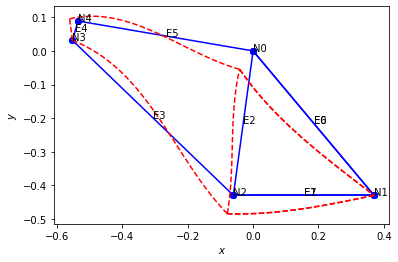

In [17]:
fmn.plot_system(show_displacement=True,magnification=500)

In [8]:
def frame(w, d1, A1, I1, d2, A2, I2, Fs, Fh, Fp): #Use standard pipe sizes found in Shigley, along with worst case loading
    # Aluminium 6061-T4
    E = 68.9e9
    Sy = 145e6
    Sut = 241e6
    rho = 2700
    
    d_main = d1
    A_main = A1
    I_mian = I1
    d_rear = d2
    A_rear = A2
    I_rear = I2

    nodecoor = np.array([
                         [0, 0],        
                         [370e-3, -430e-3],
                         [-60.43e-3, -430e-3],
                         [-552.94e-3,31.62e-3], 
                         [-535.4e-3, 89e-3]]) 

    elemconn = np.array([
                         [0,1],
                         [1,2],
                         [2,0],
                         [2,3],
                         [3,4],
                         [4,0],
                         [0,1],
                         [1,2]])

    prescribed_displacement = np.array([
                                        [3,0,0], #Fix Nodes 3 and 1; attachment of front fork and rear wheel.
                                        [3,1,0],
                                        [1,0,0],
                                        [1,1,0]])

    prescribed_forces = np.array([
                                [0, 1, -Fs],
                                [2, 1, -Fp],
                                [4, 1, -Fh]])

    # Element properties
    elemprop = {}
    # Young's modulus [Pa]
    elemprop["E"] = np.ones(elemconn.shape[0]) * E
    # Area moment of inertia [m^4]
    elemprop["I"] = np.array([I_rear, I_rear,I_main,I_main,I_main,I_main,I_rear,I_rear])
    # Cross-sectional area [m^2]
    elemprop["A"] = np.array([A_rear, A_rear,A_main,A_main,A_main,A_main,A_rear,A_rear])
    # Density [kg/m^3]
    elemprop["density"] = np.ones(elemconn.shape[0]) * rho

    fmn = sfem.FEM_Beam_2D(nodecoor,                
                           elemconn,                
                           prescribed_displacement, 
                           prescribed_forces,       
                           elemprop)    
    fmn.solve()
    
    Mff,Kff = fmn.dynamic_make_matrices()
    _,Fss1,_ = fmn.make_force_global(0,1,-Fs)
    _,Fss2,_ = fmn.make_force_global(2,1,-Fp)
    _,Fss3,_ = fmn.make_force_global(4,1,-Fh)
    Fss = Fss1 + Fss2 + Fss3
    Uss = np.linalg.solve(Kff - Mff*w**2,Fss)
    U_global = fmn.dynamic_make_global_displacement(Uss)
    
    stress_top = []
    stress_bot = []
    SFbu = []
    S_a = []
    rear = [0, 1, 6, 7]
    main = [2, 3, 4, 5]
    c1_top = -((d_main/2)/I_main)
    c2_top = -((d_rear/2)/I_rear)
    c1_bot = -((-d_main/2)/I_main)
    c2_bot = -((-d_rear/2)/I_rear)
    
    for i in np.arange(fmn.nelem):
        if i in rear:
            dict_moment = fmn.post_get_bending_moment(i,npoints=10, displacement=U_global)
            St = (dict_moment["moment"]*c2_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
            Sb = (dict_moment["moment"]*c2_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
            stress_top.append(St)
            stress_bot.append(Sb)
            
            Pcr = np.pi**2 * E * I_rear/((0.5*lengths[i])**2) #fixed-fixed: K = 0.5
            P = fmn.post_axial_stress_strain(displacement=U_global)['stress'][i]*A_rear
            
            stress_a = max(max(St), max(Sb))
            S_a.append(stress_a)
            
            if P < 0:
                SFbu.append(Pcr/abs(P))
            
        elif i in main:
            dict_moment = fmn.post_get_bending_moment(i,npoints=10, displacement=U_global)
            St = (dict_moment["moment"]*c1_top + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
            Sb = (dict_moment["moment"]*c1_bot + fmn.post_axial_stress_strain(displacement=U_global)['stress'][i])
            stress_top.append(St)
            stress_bot.append(Sb)
            
            Pcr = np.pi**2 * E * I_main/((0.5**lengths[i])**2) #fixed-fixed: K = 0.5
            P = fmn.post_axial_stress_strain(displacement=U_global)['stress'][i]*A_main
            
            stress_a = max(max(St), max(Sb))
        
            S_a.append(stress_a)
            
            if P < 0:
                SFbu.append(Pcr/abs(P))
            
    stress_top_c = np.concatenate(stress_top)
    stress_bot_c = np.concatenate(stress_bot)
    
    max_comp_top = min(stress_top_c)
    max_comp_bot = min(stress_top_c)
    max_ten_top = max(stress_top_c)
    max_ten_bot = max(stress_top_c)
    
    max_comp = min(max_comp_bot, max_comp_top)
    max_ten = max(max_ten_bot, max_ten_top)
    
    Sut_MPa = Sut/1e6
    Se_acc_MPa = 0.5*Sut_MPa

    ka = marin_surface_factor(Sut_MPa, "machined")
    kb = 1
    kc = marin_loading_factor("axial") #more conservative than bending
    kd = marin_temperature_factor(50) #conservative
    ke = marin_reliability_factor(0.999)
    Se_MPa = Se_acc_MPa*ka*kb*kc*kd*ke

    stress_a_MPa = max(S_a)/1e6
    stress_m_MPa = 0

    SFy = Sy/max_ten
    SFb = min(SFbu)

    LS = stress_a_MPa/Se_MPa + stress_m_MPa/Sut_MPa
    SFf = 1/LS

    SFy = Sy/max_ten
    SFb = min(SFbu)
    
    return SFy, SFb, SFf

In [9]:
SF = []

for i in std_sizes.keys():
    d1 = std_sizes[i][0]
    A1 = std_sizes[i][2]
    I1 = std_sizes[i][3]
    for j in std_sizes.keys():
        d2 = std_sizes[j][0]
        A2 = std_sizes[j][2]
        I2 = std_sizes[j][3]
        SF1, SF2, SF3 = frame(523.8, d1, A1, I1, d2, A2, I2, 490.5, 490.5, 490.5)
        SF.append([i, j, SF1, SF2, SF3])

In [10]:
SF

[['12x2', '12x2', 8.776766711588058, 9.413754696949296, 3.860782578358886],
 ['12x2', '16x2', 8.749729496797212, 9.388151553948495, 3.851644279211873],
 ['12x2', '16x3', 8.706747085826112, 9.373253896467098, 3.8206467206367867],
 ['12x2', '20x4', 8.58375440346463, 9.328668713206724, 3.778772288149031],
 ['12x2', '25x4', 8.48797836037223, 9.286250439691402, 3.765780099728329],
 ['12x2', '25x5', 8.408916533961273, 9.272518767908252, 3.727802243632114],
 ['12x2', '30x4', 8.398142943924329, 9.252109633799202, 3.74876251209164],
 ['12x2', '30x5', 8.299246857168937, 9.234742391752887, 3.702711721380857],
 ['12x2', '42x4', 8.19462887377431, 9.195901252009302, 3.6842261862030017],
 ['12x2', '42x5', 8.046927307040633, 9.17119337604059, 3.6154561189574985],
 ['12x2', '50x4', 8.060219553833436, 9.167943864736491, 3.629865586454079],
 ['12x2', '50x5', 7.87852713558697, 9.137815772204393, 3.545218515216362],
 ['16x2', '12x2', 10.665496279529929, 9.56290073450241, 4.48436860625674],
 ['16x2', '16x2'

In [11]:
SF_1 = []

for i in std_sizes.keys():
    d1 = std_sizes[i][0]
    A1 = std_sizes[i][2]
    I1 = std_sizes[i][3]
    for j in std_sizes.keys():
        d2 = std_sizes[j][0]
        A2 = std_sizes[j][2]
        I2 = std_sizes[j][3]
        SF1, SF2, SF3 = frame(523.8, d1, A1, I1, d2, A2, I2, 490.5*3, 0, 0)
        SF_1.append([i, j, SF1, SF2, SF3])

In [12]:
SF_1

[['12x2', '12x2', 5.77416215542611, 9.935207048270787, 2.4210710972314957],
 ['12x2', '16x2', 5.766517023048104, 9.994812265062109, 2.418245009601765],
 ['12x2', '16x3', 5.734117016391683, 9.985038574483484, 2.3979176100369086],
 ['12x2', '20x4', 5.659996842550029, 10.01171937934832, 2.3744749976827912],
 ['12x2', '25x4', 5.603875111844862, 10.084185299311779, 2.3703015977768667],
 ['12x2', '25x5', 5.54576681983961, 10.037835326843242, 2.3451413998725736],
 ['12x2', '30x4', 5.545385728728299, 10.140496050491604, 2.361888538100543],
 ['12x2', '30x5', 5.472907354664239, 10.08587660400347, 2.3314011709217453],
 ['12x2', '42x4', 5.401871100514047, 10.228639356158563, 2.3220974631625984],
 ['12x2', '42x5', 5.294041920424801, 10.153763837795701, 2.2764900301945596],
 ['12x2', '50x4', 5.3035122081231725, 10.29763009723902, 2.286725683623766],
 ['12x2', '50x5', 5.171363920205451, 10.218237002159599, 2.230662783730521],
 ['16x2', '12x2', 6.758912823936561, 9.164216667898975, 2.6859139147640283]

In [13]:
SF_2 = []

for i in std_sizes.keys():
    d1 = std_sizes[i][0]
    A1 = std_sizes[i][2]
    I1 = std_sizes[i][3]
    for j in std_sizes.keys():
        d2 = std_sizes[j][0]
        A2 = std_sizes[j][2]
        I2 = std_sizes[j][3]
        SF1, SF2, SF3 = frame(523.8, d1, A1, I1, d2, A2, I2, 0, 490.5*3, 0)
        SF_2.append([i, j, SF1, SF2, SF3])

In [14]:
SF_2

[['12x2', '12x2', 28.23042336906983, 3.5610394860362082, 12.988963101241618],
 ['12x2', '16x2', 29.07058385740206, 3.5585014264985637, 13.535809361708186],
 ['12x2', '16x3', 28.818413768916606, 3.55601039848174, 13.430395851939368],
 ['12x2', '20x4', 30.683979041673226, 3.555921167401796, 14.553201092827488],
 ['12x2', '25x4', 34.10920467088805, 3.557946288045573, 16.545249490969237],
 ['12x2', '25x5', 34.06741232283297, 3.558114897397213, 16.537857368978027],
 ['12x2', '30x4', 37.30830273015398, 3.559672774515829, 18.432801399757302],
 ['12x2', '30x5', 37.35089932132354, 3.560140447882343, 18.479503912686525],
 ['12x2', '42x4', 42.20939460248685, 3.562288353133571, 20.961060021500895],
 ['12x2', '42x5', 42.08987009019132, 3.5632613169123184, 20.901704503615314],
 ['12x2', '50x4', 43.99902679625436, 3.5634527613133904, 21.84978605472765],
 ['12x2', '50x5', 43.77409782602198, 3.564760645621849, 21.738086996022425],
 ['16x2', '12x2', 27.896826226051115, 3.547235401166593, 12.714978784185

In [15]:
SF_3 = []

for i in std_sizes.keys():
    d1 = std_sizes[i][0]
    A1 = std_sizes[i][2]
    I1 = std_sizes[i][3]
    for j in std_sizes.keys():
        d2 = std_sizes[j][0]
        A2 = std_sizes[j][2]
        I2 = std_sizes[j][3]
        SF1, SF2x, SF2 = frame(523.8, d1, A1, I1, d2, A2, I2, 0, 0, 490.5*3)
        SF_3.append([i, j, SF1, SF2, SF3])

In [16]:
SF_3

[['12x2', '12x2', 4.763689023210591, 2.067726057396521, 15.572160203307359],
 ['12x2', '16x2', 4.725761685649389, 2.0624894814357195, 15.572160203307359],
 ['12x2', '16x3', 4.68994351206604, 2.047151072630999, 15.572160203307359],
 ['12x2', '20x4', 4.605160906360358, 2.0254520268774177, 15.572160203307359],
 ['12x2', '25x4', 4.54467083341314, 2.0183633209103498, 15.572160203307359],
 ['12x2', '25x5', 4.5027010105954455, 1.999681535554581, 15.572160203307359],
 ['12x2', '30x4', 4.493162688001507, 2.009781101479345, 15.572160203307359],
 ['12x2', '30x5', 4.44216674461169, 1.9871780262362413, 15.572160203307359],
 ['12x2', '42x4', 4.38660082292955, 1.9781545428986085, 15.572160203307359],
 ['12x2', '42x5', 4.312884603864887, 1.9443702254162971, 15.572160203307359],
 ['12x2', '50x4', 4.319751497929632, 1.951549153805092, 15.572160203307359],
 ['12x2', '50x5', 4.2297355982823435, 1.9098370212385993, 15.572160203307359],
 ['16x2', '12x2', 5.762030872625958, 2.371464777150817, 15.572160203307